## Load packages

In [574]:
using GLMakie, CairoMakie, Quantica

cairodefaults = (
    figure = (resolution = (900,500),),
    axis2D = (xticklabelsize = 20, yticklabelsize = 20, xlabelsize = 30, ylabelsize = 30),
    axis3D = (xticklabelsize = 20, yticklabelsize = 20, zticklabelsize = 20, xlabelsize = 30, ylabelsize = 30, zlabelsize = 30));

gldefaults = (
    figure = (resolution = (1430,2170),),
    axis2D = (xticklabelsize = 40, yticklabelsize = 40),
    axis3D = (xticklabelsize = 30, yticklabelsize = 30, zticklabelsize = 30),
    inspector = (fontsize = 30,));

# GLMakie.activate!(); qplotdefaults(gldefaults);      # windowed OpenGL graphics
CairoMakie.activate!(); qplotdefaults(cairodefaults);  # inline SVG graphics


## Lattices

### Building a honeycomb lattice by hand

In [575]:
sA, sB = sublat((0, -1/(2√3)), name = :Boron),
         sublat((0,  1/(2√3)), name = :Nitrogen);

A₁, A₂ = (cos(π/3), sin(π/3)), (-cos(π/3), sin(π/3));

lat = lattice(sA, sB; bravais = (A₁, A₂))


Lattice{Float64,2,2} : 2D lattice in 2D space
  Bravais vectors : [[0.5, 0.866025], [-0.5, 0.866025]]
  Sublattices     : 2
    Names         : (:Boron, :Nitrogen)
    Sites         : (1, 1) --> 2 total per unit cell

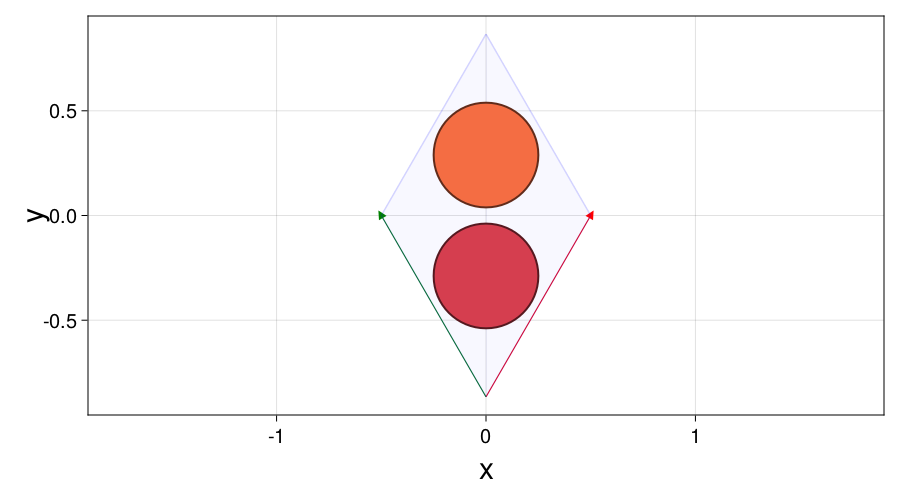

In [576]:
qplot(lat, hide = nothing)


### LatticePresets (aka LP)

In [578]:
LatticePresets.honeycomb(names = (:Boron, :Nitrogen))  # also triangular, square, cubic, fcc, bcc...


Lattice{Float64,2,2} : 2D lattice in 2D space
  Bravais vectors : [[0.5, 0.866025], [-0.5, 0.866025]]
  Sublattices     : 2
    Names         : (:Boron, :Nitrogen)
    Sites         : (1, 1) --> 2 total per unit cell

### Transforming lattices

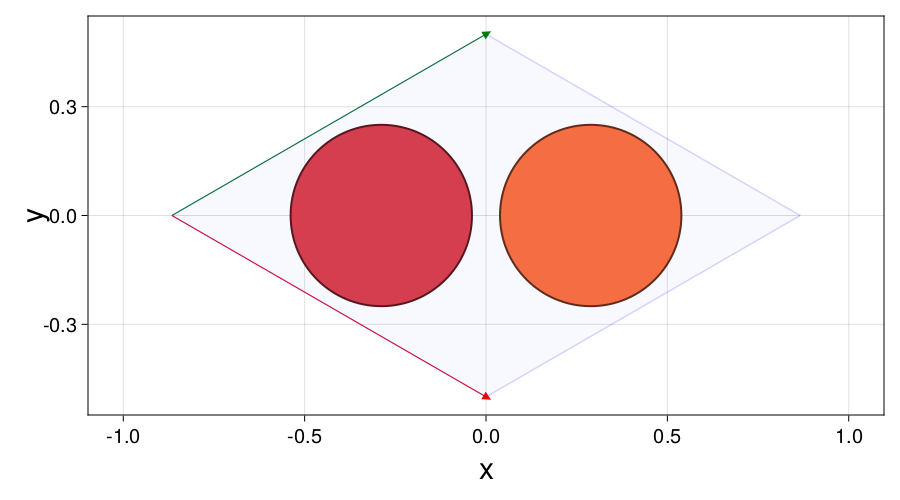

In [579]:
transform(lat, r -> SA[0 1; -1 0] * r) |> qplot(; hide = nothing)


Currying syntax
```
x |> f             == f(x)                # general Julia syntax
x |> f(y...; z...) == f(x, y...; z...)    # with most Quantica commands
```

### Superlattices

In [580]:
slat = supercell(lat, 3)


Lattice{Float64,2,2} : 2D lattice in 2D space
  Bravais vectors : [[1.5, 2.598076], [-1.5, 2.598076]]
  Sublattices     : 2
    Names         : (:Boron, :Nitrogen)
    Sites         : (9, 9) --> 18 total per unit cell

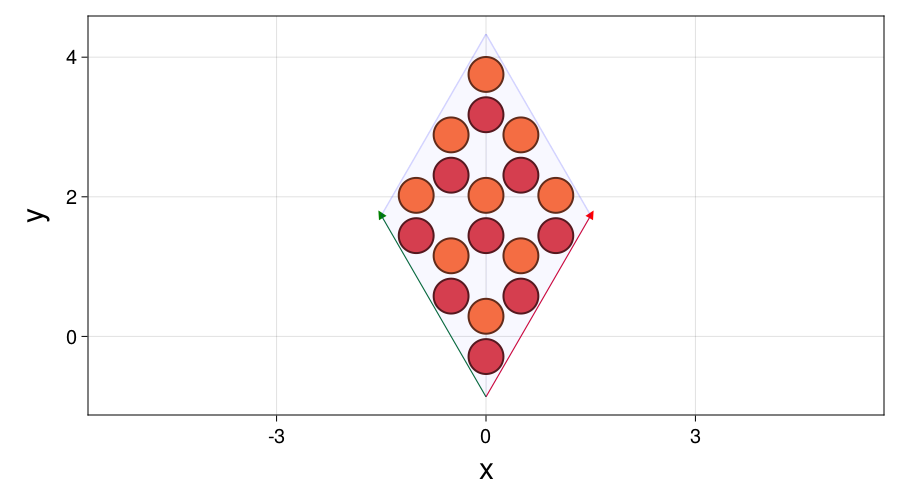

In [581]:
qplot(slat, hide = nothing)


We can also change the lattice dimensions by defining new Bravais vectors

In [582]:
slat = supercell(lat, (10, -10), region = r -> -11 <= r[2] <= 11)


Lattice{Float64,2,1} : 1D lattice in 2D space
  Bravais vectors : [[10.0, -0.0]]
  Sublattices     : 2
    Names         : (:Boron, :Nitrogen)
    Sites         : (260, 260) --> 520 total per unit cell

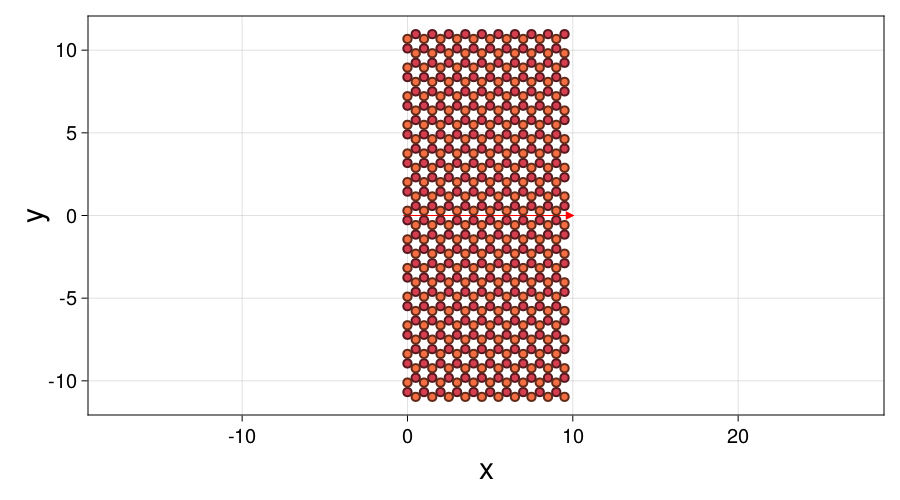

In [583]:
qplot(slat, hide = nothing)


### LatticeSlice
`LatticeSlice`: like a view into specific unit cells and sites of a `Lattice`, specified by a selector


In [584]:
latslice = lat[region = r -> norm(r) <= 10, sublats = :Boron]


LatticeSlice{Float64,2,2} : collection of subcells for a 2D lattice in 2D space
  Cells       : 363
  Cell range  : ([-11, -11], [11, 11])
  Total sites : 363

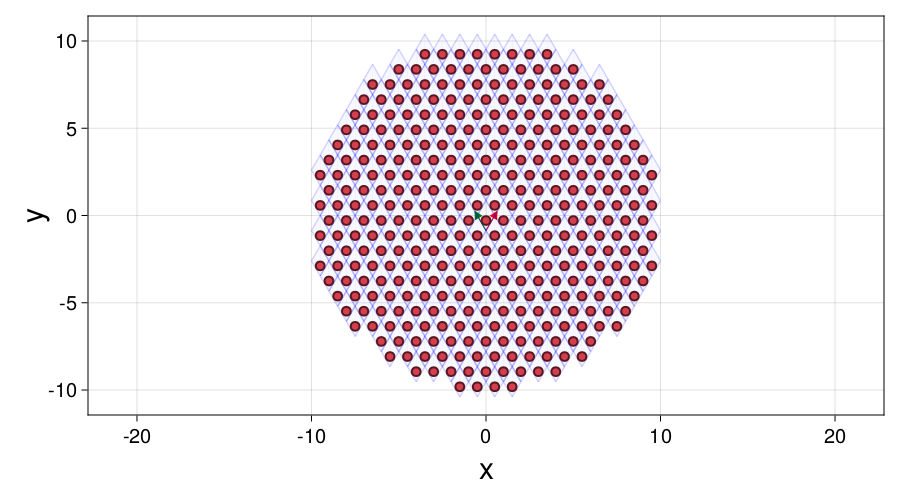

In [585]:
qplot(latslice, hide = nothing)


## Models

### Position independent terms

In [586]:
model = onsite(3) - hopping(1)


TightbindingModel: model with 2 terms
  OnsiteTerm{Int64}:
    Region            : any
    Sublattices       : any
    Cells             : any
    Coefficient       : 1
  HoppingTerm{Int64}:
    Region            : any
    Sublattice pairs  : any
    Cell distances    : any
    Hopping range     : Neighbors(1)
    Reverse hops      : false
    Coefficient       : -1

By default `hopping` is defined to nearest neighbors, but we can adjust that

In [587]:
hopping(1, range = neighbors(2))


TightbindingModel: model with 1 term
  HoppingTerm{Int64}:
    Region            : any
    Sublattice pairs  : any
    Cell distances    : any
    Hopping range     : Neighbors(2)
    Reverse hops      : false
    Coefficient       : 1

In [589]:
hopping(1, range = 2)


TightbindingModel: model with 1 term
  HoppingTerm{Int64}:
    Region            : any
    Sublattice pairs  : any
    Cell distances    : any
    Hopping range     : 2.0
    Reverse hops      : false
    Coefficient       : 1

### Position dependent terms

In [517]:
m1 = onsite(r -> r[1])


TightbindingModel: model with 1 term
  OnsiteTerm{Function}:
    Region            : any
    Sublattices       : any
    Cells             : any
    Coefficient       : 1

In [518]:
m2 = hopping((r, dr) -> im*dr[2])


TightbindingModel: model with 1 term
  HoppingTerm{Function}:
    Region            : any
    Sublattice pairs  : any
    Cell distances    : any
    Hopping range     : Neighbors(1)
    Reverse hops      : false
    Coefficient       : 1

### What does `r` and `dr` mean for `hopping`s?

![Alt](image.png)


### Models that depend on parameters (`@onsite` and `@hopping`)

We can give default values for parameters

In [519]:
model = @onsite((r; t = 1, μ) -> 2t - μ + r[1]) + @hopping((; t = 1) -> -t)


ParametricModel: model with 2 terms
  ParametricOnsiteTerm{ParametricFunction{1}}
    Region            : any
    Sublattices       : any
    Cells             : any
    Coefficient       : 1
    Parameters        : [:t, :μ]
  ParametricHoppingTerm{ParametricFunction{0}}
    Region            : any
    Sublattice pairs  : any
    Cell distances    : any
    Hopping range     : Neighbors(1)
    Reverse hops      : false
    Coefficient       : 1
    Parameters        : [:t]

### Constraining models with Selectors

In [520]:
m3 = onsite(3; region = r -> norm(r) < 2)


TightbindingModel: model with 1 term
  OnsiteTerm{Int64}:
    Region            : Function
    Sublattices       : any
    Cells             : any
    Coefficient       : 1

In [521]:
m4 = hopping(3; sublats = :A => :B, range = 2, region = (r, dr) -> norm(r) < 2)


TightbindingModel: model with 1 term
  HoppingTerm{Int64}:
    Region            : Function
    Sublattice pairs  : :A => :B
    Cell distances    : any
    Hopping range     : 2.0
    Reverse hops      : false
    Coefficient       : 1

### Linear combinations of models

In [590]:
model = 2*m3 - m4 - m4'


TightbindingModel: model with 3 terms
  OnsiteTerm{Int64}:
    Region            : Function
    Sublattices       : any
    Cells             : any
    Coefficient       : 2
  HoppingTerm{Int64}:
    Region            : Function
    Sublattice pairs  : :A => :B
    Cell distances    : any
    Hopping range     : 2.0
    Reverse hops      : false
    Coefficient       : -1
  HoppingTerm{Int64}:
    Region            : Function
    Sublattice pairs  : :A => :B
    Cell distances    : any
    Hopping range     : 2.0
    Reverse hops      : true
    Coefficient       : -1

### Multiorbital models

In [523]:
modelSC = @onsite((; μ, Δ) -> SA[4t-μ conj(Δ); Δ μ-4t]) - @hopping((; t) -> SA[t 0; 0 -t])


ParametricModel: model with 2 terms
  ParametricOnsiteTerm{ParametricFunction{0}}
    Region            : any
    Sublattices       : any
    Cells             : any
    Coefficient       : 1
    Parameters        : [:μ, :Δ]
  ParametricHoppingTerm{ParametricFunction{0}}
    Region            : any
    Sublattice pairs  : any
    Cell distances    : any
    Hopping range     : Neighbors(1)
    Reverse hops      : false
    Coefficient       : -1
    Parameters        : [:t]

## Hamiltonians

### Simple example: graphene with next-nearest neighbor hopping

Note: `(:A,:B) .=> (:A,:B)` is equal to `(:A => :A, :B => :B)`

In [591]:
model = hopping(1) + hopping(0.5, sublats = (:A,:B) .=> (:A,:B), range = 1);
h = hamiltonian(LP.honeycomb(), model)


Hamiltonian{Float64,2,2}: Hamiltonian on a 2D Lattice in 2D space
  Bloch harmonics  : 7
  Harmonic size    : 2 × 2
  Orbitals         : [1, 1]
  Element type     : scalar (ComplexF64)
  Onsites          : 0
  Hoppings         : 18
  Coordination     : 9.0

The `h` above is equivalent to

In [592]:
h = LP.honeycomb() |> model


Hamiltonian{Float64,2,2}: Hamiltonian on a 2D Lattice in 2D space
  Bloch harmonics  : 7
  Harmonic size    : 2 × 2
  Orbitals         : [1, 1]
  Element type     : scalar (ComplexF64)
  Onsites          : 0
  Hoppings         : 18
  Coordination     : 9.0

GPU-accelerated interactive visualization

In [593]:
GLMakie.activate!(); qplotdefaults(gldefaults);


In [594]:
qplot(h, inspector = true)


### Multiorbital parameter-dependent Hamiltonian

In [595]:
model = @hopping((; t = 1) -> -t* SA[0 1; 1 0]) +
        @onsite((r; t = 1, E = SA[1,0,0]) -> 2t*I + dot(E, r) * I);


In [596]:
h = LP.cubic() |> supercell(4) |> hamiltonian(model, orbitals = 2)


ParametricHamiltonian{Float64,3,3}: Parametric Hamiltonian on a 3D Lattice in 3D space
  Bloch harmonics  : 7
  Harmonic size    : 64 × 64
  Orbitals         : [2]
  Element type     : 2 × 2 blocks (ComplexF64)
  Onsites          : 64
  Hoppings         : 384
  Coordination     : 6.0
  Parameters       : [:E, :t]

In [597]:
h(E = SA[1,1,1])


Hamiltonian{Float64,3,3}: Hamiltonian on a 3D Lattice in 3D space
  Bloch harmonics  : 7
  Harmonic size    : 64 × 64
  Orbitals         : [2]
  Element type     : 2 × 2 blocks (ComplexF64)
  Onsites          : 64
  Hoppings         : 384
  Coordination     : 6.0

In [598]:
qplot(h, inspector = true, flat = false)


### A bigger lattice: ∼6⋅10⁵ sites, ∼4⋅10⁶ hoppings

In [654]:
funky_region((x,y,z)) = norm(SA[x/4,y/4,z]) < 40 && hypot(x,y) < 40*(1+(z/40)^2)
model = hopping(1) + @onsite((r; E = SA[0,0,0]) -> dot(E,r))
@time hbig = LP.cubic() |> model |> supercell(region = funky_region)


  1.282927 seconds (1.52 M allocations: 549.630 MiB, 57.07% compilation time)


ParametricHamiltonian{Float64,3,0}: Parametric Hamiltonian on a 0D Lattice in 3D space
  Bloch harmonics  : 1
  Harmonic size    : 665803 × 665803
  Orbitals         : [1]
  Element type     : scalar (ComplexF64)
  Onsites          : 665803
  Hoppings         : 3909988
  Coordination     : 5.87259
  Parameters       : [:E]

Fast application of parameters

In [653]:
@time hbig(E = SA[1,0,0])
@time hbig(E = SA[1,0,0])


  0.029619 seconds (45 allocations: 130.133 MiB)
  0.025251 seconds (45 allocations: 130.133 MiB)


Hamiltonian{Float64,3,0}: Hamiltonian on a 0D Lattice in 3D space
  Bloch harmonics  : 1
  Harmonic size    : 665803 × 665803
  Orbitals         : [1]
  Element type     : scalar (ComplexF64)
  Onsites          : 665803
  Hoppings         : 3909988
  Coordination     : 5.87259

Can GLMakie handle it?

In [602]:
qplot(hbig, inspector = true)   # Yeah...!


### Getting the Hamiltonian matrix

In [603]:
qplot(h, inspector = true, flat = false)


In [604]:
@time hΓ = h((0,0,π); E = SA[1,0,0])


  0.008807 seconds (2.34 k allocations: 320.045 KiB, 97.34% compilation time)


128×128 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 1792 stored entries:
⎡⢿⣷⡟⢷⡄⠀⠀⠘⢷⡄⠻⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠳⣦⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⢿⣍⢱⣶⣼⢶⣄⠀⠀⠈⠀⠀⠱⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⣤⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠉⢲⣟⠛⣤⣍⣦⣄⠀⠀⠀⠀⠈⠑⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠓⣄⡀⠀⠀⠀⎥
⎢⣀⠀⠀⠙⠣⣽⠿⢇⣙⢣⠀⠀⠀⠀⠀⠈⠛⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢄⠀⠀⎥
⎢⠙⠷⡀⠀⠀⠙⠷⣘⣿⣿⠀⠀⠀⠀⠀⠀⠀⠈⠻⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣆⎥
⎢⠻⣦⠀⠀⠀⠀⠀⠀⠀⠀⢿⣷⡟⢷⡄⠀⠀⠘⢶⡄⠳⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠱⣦⡀⠀⠀⠀⠀⠀⢿⣍⢱⣶⣼⢦⣄⠀⠀⠈⠀⠀⠱⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠑⢤⡀⠀⠀⠀⠀⠉⠲⣟⠛⣤⣍⠦⣀⠀⠀⠀⠀⠈⠑⢄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠛⢄⡀⠀⣀⠀⠀⠙⠣⡝⠿⢇⣙⢣⠀⠀⠀⠀⠀⠈⠻⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠻⢆⠘⠷⡀⠀⠀⠘⠷⣘⢿⣷⠀⠀⠀⠀⠀⠀⠀⠀⠻⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣦⠀⠀⠀⠀⠀⠀⠀⠀⢿⣷⡍⢶⡄⠀⠀⠈⢶⡄⠱⣦⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⣦⡀⠀⠀⠀⠀⠀⢣⣍⢱⣶⣜⢢⣄⠀⠀⠉⠀⠈⠑⣤⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠑⢄⡀⠀⠀⠀⠀⠉⠲⣙⠛⣤⣽⠦⣀⠀⠀⠀⠀⠈⠓⢄⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢆⠀⠀⡀⠀⠀⠙⠳⡟⠿⢇⣙⣷⠀⠀⠀⠀⠀⠈⠻⢆⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢦⠘⠷⡄⠀⠀⠘⢷⣼⢿⣷⠀⠀⠀⠀⠀⠀⠀⠀⠻⣦⎥
⎢⠹⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⣦⡀⠀⠀⠀⠀⠀⠀⠀⣿⣿⡍⢶⣄⠀⠀⠈⢶⣄⎥
⎢⠀⠀⠑⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⣤⡀⠀⠀⠀⠀⠀⢣⣍⢱⣶⣟⢢⣄⠀⠀⠉⎥
⎢⠀⠀⠀⠈⠙⢤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢄⡀⠀⠀⠀⠀⠙⠻⣙⠛⣤⣽⠧⣀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠛⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢆⠀⠀⡀⠀⠀⠙⠷⡟⠿⢇⣙⣷⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠻⢦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣦⠘⢷⡄⠀⠀⠘⢷⣼⢿⣷⎦

In [605]:
Matrix(hΓ)


128×128 Matrix{ComplexF64}:
  2.0+0.0im           0.0+0.0im           0.0+0.0im  …   0.0+0.0im
  0.0+0.0im           2.0+0.0im          -1.0+0.0im      0.0+0.0im
  0.0+0.0im          -1.0+0.0im           2.0+0.0im      0.0+0.0im
 -1.0+0.0im           0.0+0.0im           0.0+0.0im      0.0+0.0im
  0.0+0.0im           0.0+0.0im           0.0+0.0im      0.0+0.0im
  0.0+0.0im           0.0+0.0im          -1.0+0.0im  …   0.0+0.0im
 -0.0+0.0im           1.0-1.22465e-16im   0.0+0.0im      0.0+0.0im
  1.0-1.22465e-16im  -0.0+0.0im           0.0+0.0im      0.0+0.0im
  0.0+0.0im          -1.0+0.0im           0.0+0.0im      0.0+0.0im
 -1.0+0.0im           0.0+0.0im           0.0+0.0im      0.0+0.0im
     ⋮                                               ⋱  
  0.0+0.0im           0.0+0.0im           0.0+0.0im      0.0+0.0im
  0.0+0.0im           0.0+0.0im           0.0+0.0im  …   1.0+1.22465e-16im
  0.0+0.0im           0.0+0.0im           0.0+0.0im      0.0+0.0im
  0.0+0.0im           0.0+0.0im     

If we need a specific harmonic (n₁, n₂,...) we use the `getindex` syntax

In [538]:
h(E = SA[1,0,0])[(1,0,0)]


128×128 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 64 stored entries:
⎡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠳⣦⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⣤⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠓⣄⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣆⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

## Bandstructures

### A simple graphene bandstructure

In [606]:
h = HamiltonianPresets.graphene(a0 = 1)


Hamiltonian{Float64,2,2}: Hamiltonian on a 2D Lattice in 2D space
  Bloch harmonics  : 5
  Harmonic size    : 2 × 2
  Orbitals         : [1, 1]
  Element type     : scalar (ComplexF64)
  Onsites          : 0
  Hoppings         : 6
  Coordination     : 3.0

In [607]:
qplot(h)


In [608]:
spectrum(h, (0, 0))


Spectrum{Float64,ComplexF64} :
Energies:
2-element Vector{ComplexF64}:
 -8.100000000000001 + 0.0im
  8.100000000000001 + 0.0im
States:
2×2 Matrix{ComplexF64}:
 -0.707107+0.0im  0.707107+0.0im
  0.707107+0.0im  0.707107+0.0im

In [609]:
ϕᵢ = subdiv(0, 2π, 31)
b = bands(h, ϕᵢ, ϕᵢ)


Bandstructure{Float64,3,2}: 3D Bandstructure over a 2-dimensional parameter space of type Float64
  Subbands  : 1
  Vertices  : 1920
  Edges     : 5520
  Simplices : 3600

Bandstructure calculations are multithreaded and interpolated (using eigenstate overlap, possibly degenerate)

In [610]:
qplot(b, inspector = true)


### Bandstructure slicing (Fermi surfaces)

Cubic lattice with Zeeman, isoenergy surface at energy = -0.9

In [611]:
h = LP.cubic() |> hamiltonian(onsite(SA[1 0; 0 -1]) - hopping(I), orbitals = 2)
b = bands(h, showprogress = false)


Bandstructure{Float64,4,3}: 4D Bandstructure over a 3-dimensional parameter space of type Float64
  Subbands  : 2
  Vertices  : 235298
  Edges     : 1590048
  Simplices : 1327104

In [612]:
qplot(b[(:, :, :, -0.9)], hide = (:nodes, :wireframe), fancyaxis = false, axis = (zlabel = "ϕ₃",))


### Bandstructure linecuts

Let's turn on inline plots in Jupyter again

In [613]:
CairoMakie.activate!(); qplotdefaults(cairodefaults);


In [616]:
h = HP.graphene()
xs = [0, 1, 2, 3];
b = bands(h, subdiv(xs, 10); mapping = xs => (:Γ, :K, :M, :Γ))


Bandstructure{Float64,2,1}: 2D Bandstructure over a 1-dimensional parameter space of type Float64
  Subbands  : 1
  Vertices  : 55
  Edges     : 54
  Simplices : 54

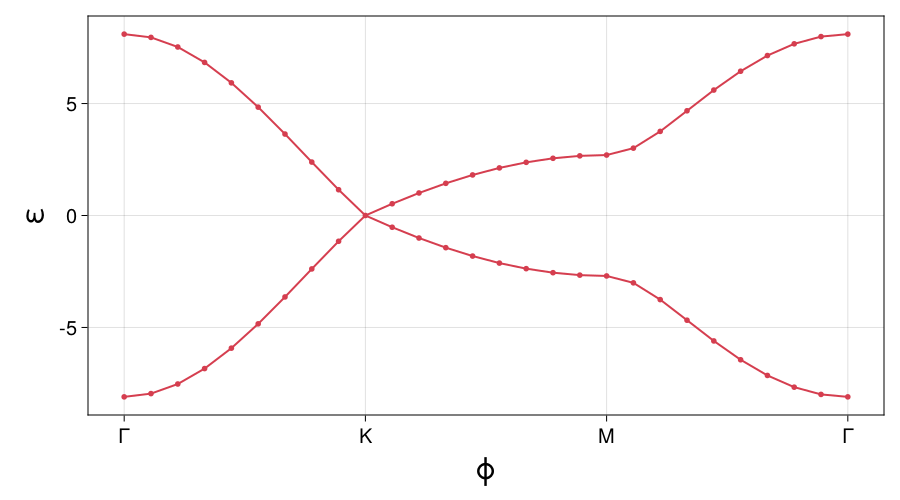

In [617]:
qplot(b, axis = (; xticks = (xs, ["Γ", "K", "M", "Γ"])))


### EigenSolvers

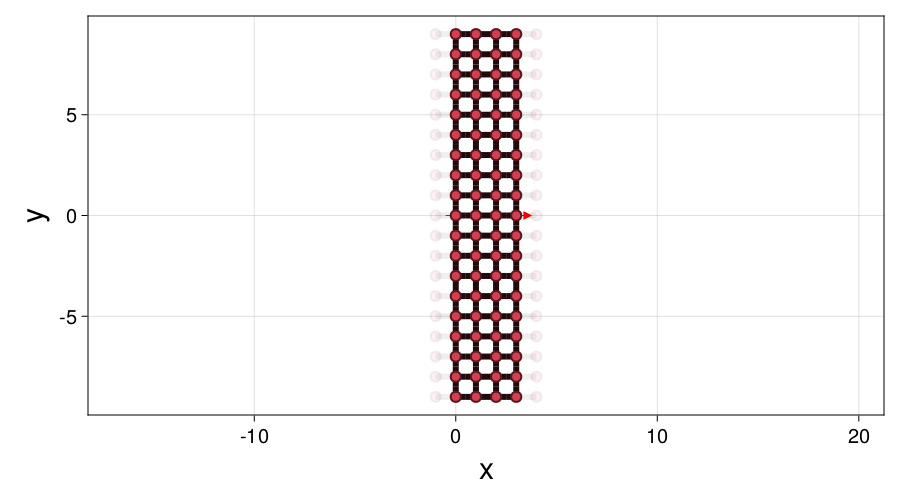

In [619]:
h = LatticePresets.square() |> hopping(4) |> supercell((4,0), region = r->abs(r[2])<10)

qplot(h)


We use an ArnoldiMethod with an LU shift-invert solver with 14 eigenpairs around zero energy

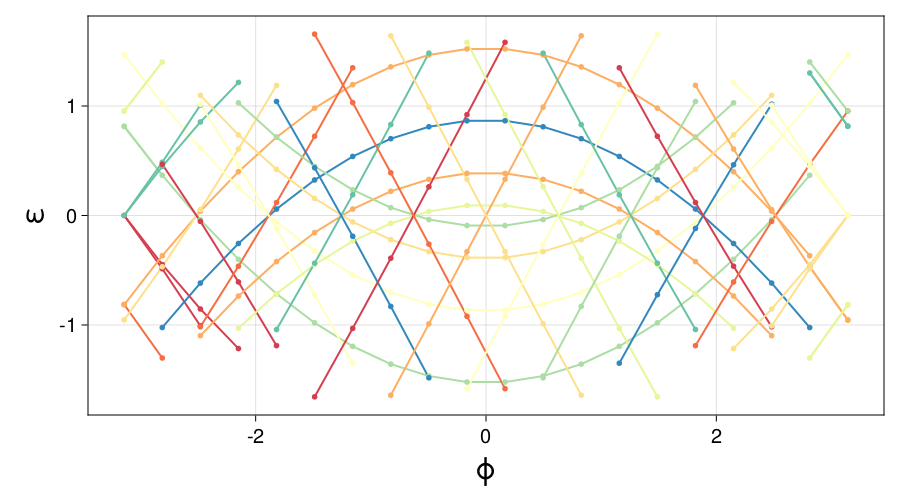

In [620]:
b = bands(h, subdiv(-π, π, 20),
    showprogress = false,
    solver = ES.ShiftInvert(ES.ArnoldiMethod(nev = 14), 0)) # ES === EigenSolvers
qplot(b)


Note that the interpolation allows us to use a coarse mesh without losing sight of the bands

For comparison, this is the same information without any interpolation

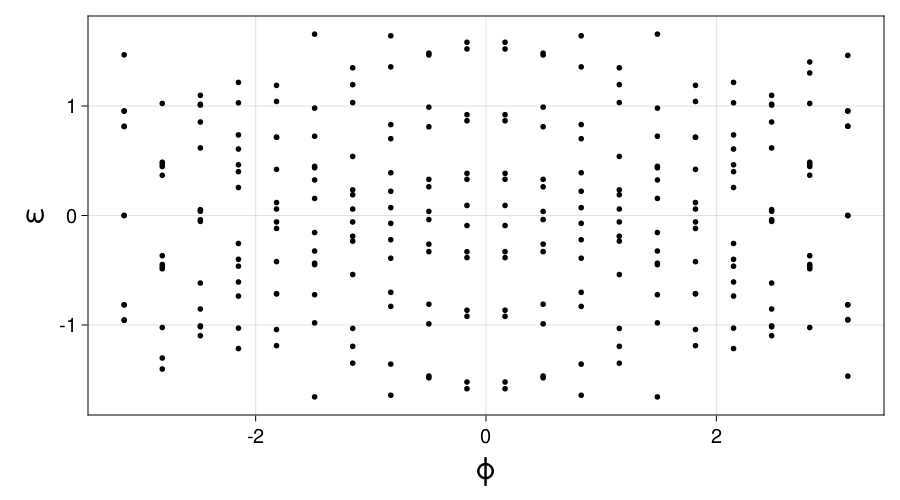

In [551]:
qplot(b, hide = :bands, color = :black)


### Bands shading

We can encode eigenstate/eigenvalue information in the color/opacity of the bands

In [621]:
# Kane-Mele spin-orbit coupling
SOC(dr) = ifelse(iseven(round(Int, atan(dr[2], dr[1])/(pi/3))), im, -im)

model = hopping(3I, range = 1/√3) +
    @hopping((r, dr; α = 0) -> α * SOC(dr); sublats = :A => :A, range = 1) -
    @hopping((r, dr; α = 0) -> α * SOC(dr); sublats = :B => :B, range = 1)

h = LatticePresets.honeycomb(a0 = 1) |> hamiltonian(model)


ParametricHamiltonian{Float64,2,2}: Parametric Hamiltonian on a 2D Lattice in 2D space
  Bloch harmonics  : 7
  Harmonic size    : 2 × 2
  Orbitals         : [1, 1]
  Element type     : scalar (ComplexF64)
  Onsites          : 0
  Hoppings         : 18
  Coordination     : 9.0
  Parameters       : [:α]

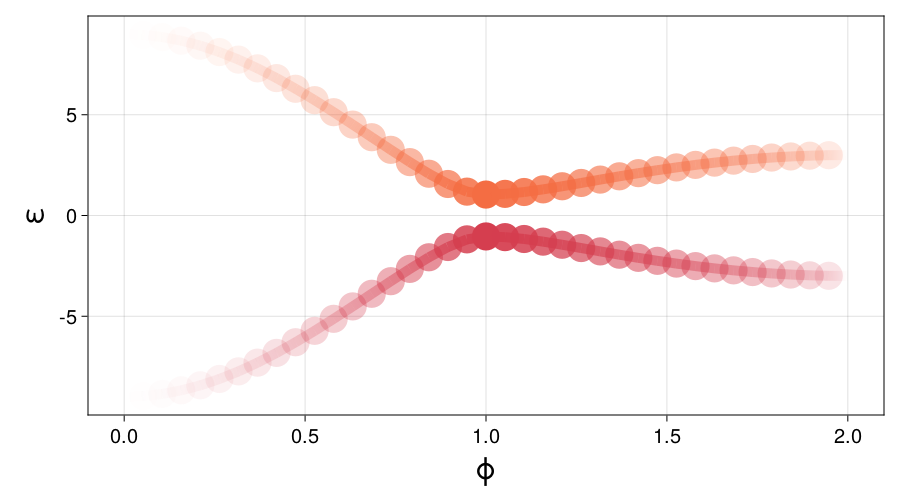

In [553]:
xs = [0,1,2]
b = bands(h(α = 0.2), subdiv(xs,20), mapping = (xs => (:Γ, :K, :M)));
qplot(b, size = 10, opacity = (psi, e, k) -> √abs(abs(psi[1]) - abs(psi[2])))


In [623]:
GLMakie.activate!(); qplotdefaults(gldefaults);

ϕ(k...) =  SA[k...]' * bravais_matrix(h)
ks = subdiv(-5,5,80)
b = bands(h(α = 0.2), ks, ks; mapping = ϕ, showprogress = false);

qplot(b,
    color = (psi, e, k) -> angle(psi[1] / psi[2]),
    opacity = (psi, e, k) -> √abs(abs(psi[1]) - abs(psi[2])),
    colormap = :cyclic_mrybm_35_75_c68_n256,
    hide = ( :wireframe),
    fancyaxis = false)


## GreenFunctions

In [624]:
g = LP.square() |>
    supercell((3,0), region = r->abs(r[2])<3) |>
    @onsite((; μ =0) -> 4-μ) - hopping(1) |>
    greenfunction(GreenSolvers.Schur())


GreenFunction{Float64,2,1}: Green function of a Hamiltonian{Float64,2,1}
  Solver          : AppliedSchurGreenSolver
  Contacts        : 0
  Contact solvers : ()
  Contact sizes   : ()
  ParametricHamiltonian{Float64,2,1}: Parametric Hamiltonian on a 1D Lattice in 2D space
    Bloch harmonics  : 3
    Harmonic size    : 15 × 15
    Orbitals         : [1]
    Element type     : scalar (ComplexF64)
    Onsites          : 15
    Hoppings         : 54
    Coordination     : 3.6  
    Parameters       : [:μ]

In [625]:
qplot(g)


We can do partial evaluation of `g` at fixed energy...

In [627]:
ω = 0.102
@time g(ω; μ = 0.2)


  0.000200 seconds (876 allocations: 373.891 KiB)


GreenSolution{Float64,2,1}: Green function at arbitrary positions, but at a fixed energy

... or at fixed positions...

In [628]:
sel = siteselector(region = r -> norm(r) < 2)
qplot!(lattice(g)[sel], sitecolor = :blue)

@time g[sel]


  0.021170 seconds (3.12 k allocations: 212.092 KiB, 99.69% compilation time)


GreenSlice{Float64,2,1}: Green function at arbitrary energy, but at a fixed lattice positions

... or do a complete evaluation

In [629]:
@time g(ω; μ = 0.2)[sel]


  0.664616 seconds (522.49 k allocations: 35.209 MiB, 99.82% compilation time)


9×9 Matrix{ComplexF64}:
 -0.246387-0.680304im  0.0571823-0.785547im  …   0.189929-0.668721im
 0.0571823-0.785547im  -0.173193-0.907071im      0.155252-0.772173im
  0.147344-0.680304im  0.0571823-0.785547im     0.0411668-0.668721im
 0.0411668-0.668721im   0.155252-0.772173im       0.27404-0.634368im
  0.155252-0.772173im   0.122584-0.891628im      0.285843-0.732505im
  0.189929-0.668721im   0.155252-0.772173im  …   0.213839-0.634368im
 0.0411668-0.668721im   0.155252-0.772173im      0.147344-0.680304im
  0.155252-0.772173im   0.122584-0.891628im     0.0571823-0.785547im
  0.189929-0.668721im   0.155252-0.772173im     -0.246387-0.680304im

## Observables

### Basic example: 0D cavity with magnetic flux

In [630]:
star_region(r) = norm(r) < 40*(1+0.2*cos(5*atan(r[2],r[1])))

g = LP.square() |>
    supercell(region = star_region) |>
    onsite(4) - @hopping((r, dr; B = 0.1) -> cis(B * dr[1] * r[2])) |>
    greenfunction

qplot(g)


Local density of states at zero flux

In [636]:
ρ = ldos(g(0.13 + 0.001im; B = 0))


LocalSpectralDensitySolution{Float64} : local density of states at fixed energy and arbitrary location
  kernel   : LinearAlgebra.UniformScaling{Bool}(true)

In [637]:
qplot(g, hide = :hops, sitecolor = ρ, siteradius = ρ,
         minmaxsiteradius = (0, 1.7), sitecolormap = :balance)


Current density at finite flux

In [638]:
J = current(g(0.1; B = 0.1))


CurrentDensitySolution{Float64} : current density at a fixed energy and arbitrary location
  charge      : LinearAlgebra.UniformScaling{Int64}(-1)
  direction   : missing

In [639]:
qplot(g, siteradius = 0.08, hopradius = J, hopcolor = J,
         sitecolor = :black, siteoutline = 0,
         minmaxhopradius = (0, 3), hopcolormap = :balance, hopdarken = 0)


### Another example: Semi-infinite superconducting nanoribbon

In [640]:
model = onsite(SA[0 0.1; 0.1 0]) + hopping(SA[1 0; 0 -1]);
lead(W) = LP.square() |> hamiltonian(model, orbitals = 2) |> supercell((1,0), region = r -> 0 <= r[2] <= W);
glead(W) = greenfunction(lead(W), GreenSolvers.Schur(boundary=0));
g = glead(30)


GreenFunction{Float64,2,1}: Green function of a Hamiltonian{Float64,2,1}
  Solver          : AppliedSchurGreenSolver
  Contacts        : 0
  Contact solvers : ()
  Contact sizes   : ()
  Hamiltonian{Float64,2,1}: Hamiltonian on a 1D Lattice in 2D space
    Bloch harmonics  : 3
    Harmonic size    : 31 × 31
    Orbitals         : [2]
    Element type     : 2 × 2 blocks (ComplexF64)
    Onsites          : 31
    Hoppings         : 122
    Coordination     : 3.93548

Compute the local density of states

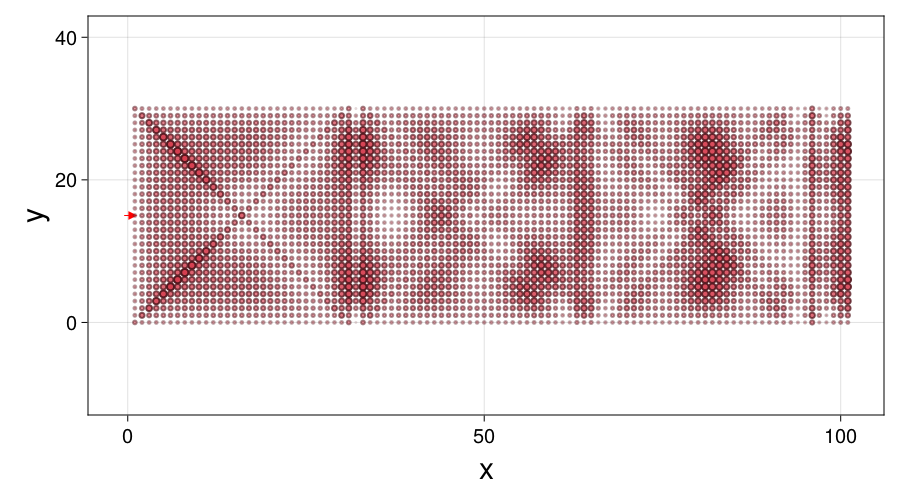

In [641]:
CairoMakie.activate!(); qplotdefaults(cairodefaults);

ω = 0.102; ρ = ldos(g(ω))

qplot(g, selector = siteselector(; cells = 1:100), siteradius = ρ, siteopacity = ρ, hide = :hops)


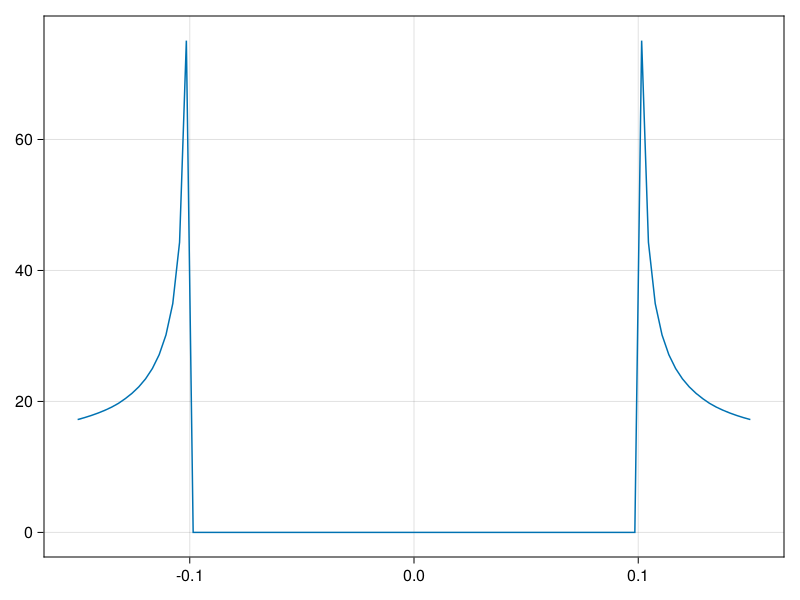

In [642]:
ρ = ldos(g[cells = 1])
ωs = subdiv(-0.15, 0.15, 100)
ρlist = [sum(ρ(ω)) for ω in ωs]

lines(ωs, ρlist)


### Attaching leads

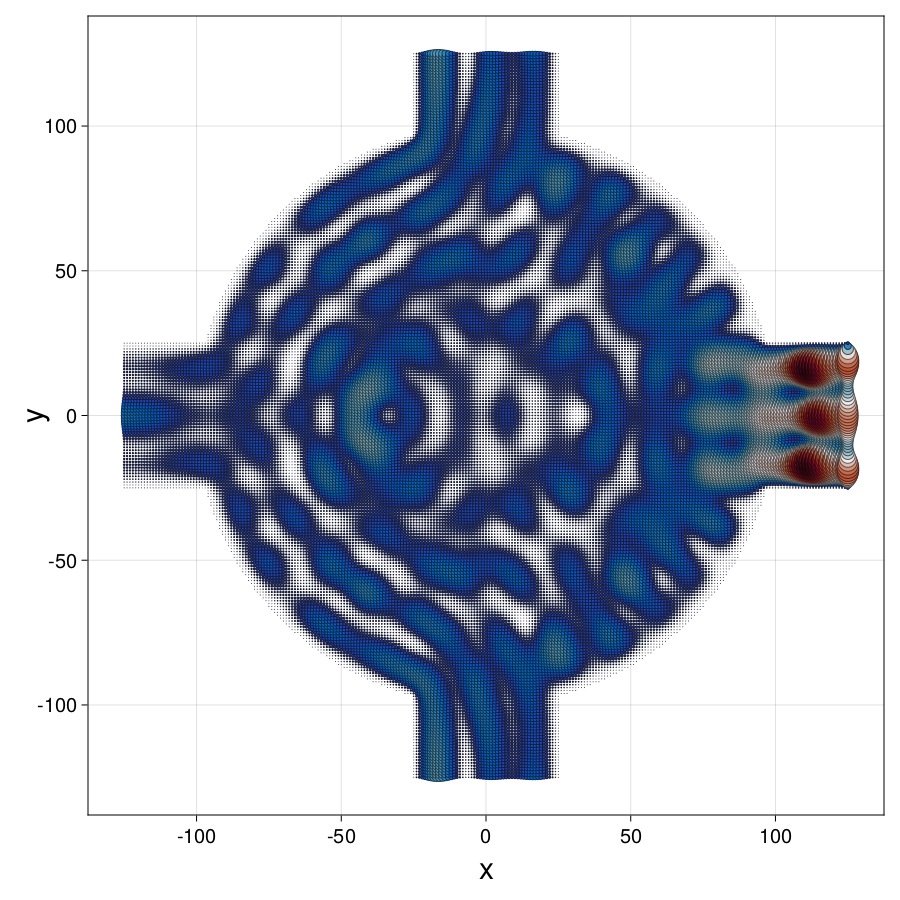

In [644]:
cavityregion = RP.circle(100) | RP.rectangle((250, 50)) | RP.rectangle((50, 250))
leadregion(r) = abs(r[2]) <= 50/2

h0 = LP.square() |> hopping(-1) |> supercell(region = cavityregion)

gl = LP.square() |> hopping(-1) |> supercell((1, 0), region = leadregion) |>
     greenfunction(GS.Schur(boundary = 0))

Rot = r -> SA[0 -1; 1 0] * r  # 90º rotation function

g = h0 |>
    attach(gl, region = r -> r[1] ==  125) |>
    attach(gl, region = r -> r[1] == -125, reverse = true) |>
    attach(gl, region = r -> r[2] ==  125, transform = Rot) |>
    attach(gl, region = r -> r[2] == -125, reverse = true, transform = Rot) |>
    greenfunction;

ω = -3.96; gx1 = abs2.(g(ω)[(), 1])

qplot(h0, hide = :hops, siteoutline = 1,
          sitecolor = gx1, siteradius = gx1,
          minmaxsiteradius = (0, 5), sitecolormap = :balance,
          figure = (resolution = (900, 900),))


Transmission and conductance (local and non-local)

In [646]:
T₄₁ = transmission(g[4, 1])
G₄₁ = conductance(g[4, 1])
G₁₁ = conductance(g[1, 1])


Conductance{Float64}: Zero-temperature conductance dIᵢ/dVⱼ from contacts i,j, in units of e^2/h
  Current contact  : 1
  Bias contact     : 1

In [647]:
G₁₁(ω), G₄₁(ω), T₄₁(ω)


(2.653177598812496, -0.9068199606495378, 0.9068199606495378)

### Band solver for higher dimensions (experimental)

In [648]:
h = LP.square() |> hopping(-1)
ϕs = subdiv(-π, π, 15)
b = bands(h, ϕs, ϕs, showprogress = false)

GLMakie.activate!(); qplotdefaults(gldefaults);
qplot(b, hide = :nodes)


In [649]:
g = h |> attach(@onsite(ω->-im), cells = SA[20,0]) |>
    greenfunction(GS.Bands(ϕs, ϕs, boundary = 1=>0))

ω = -1
sel2D = siteselector(cells = CartesianIndices((1:60, -30:30)))
gx1 = g(ω)[sel2D, 1];


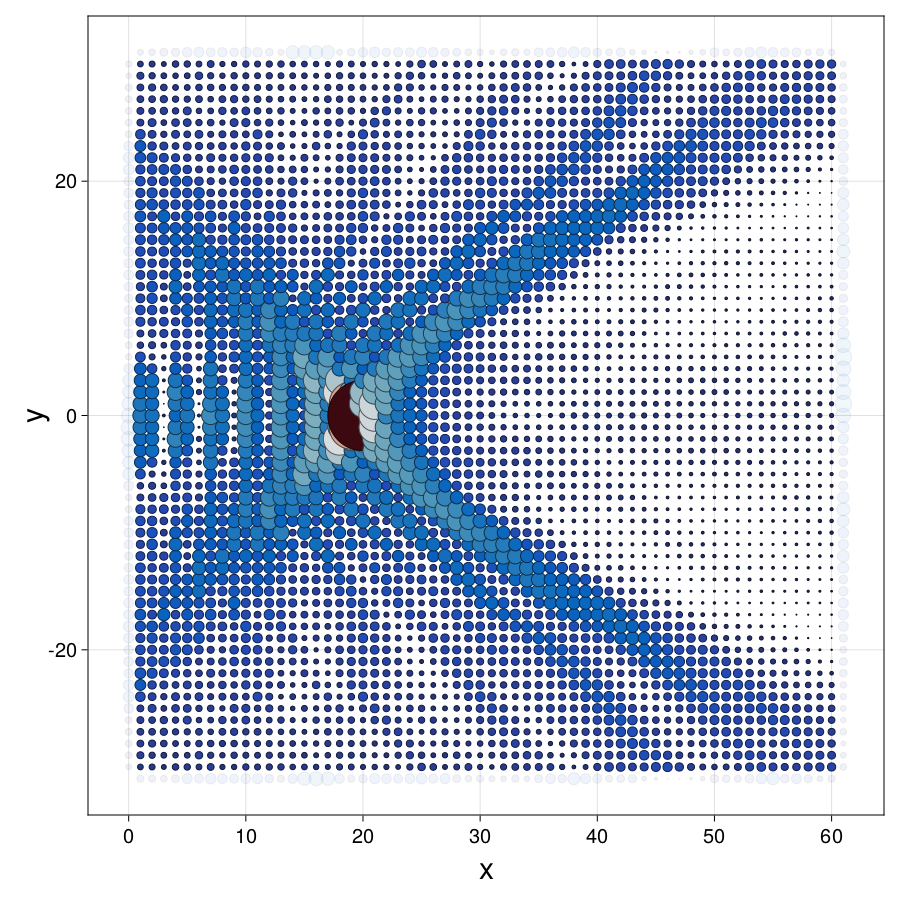

In [573]:
CairoMakie.activate!(); qplotdefaults(cairodefaults);

qplot(g, selector = sel2D, siteradius = abs.(gx1), sitecolor = abs.(gx1),
    minmaxsiteradius = (0, 3),
    sitecolormap = :balance, hide = (:cells,:hops,:bravais), siteoutline = 1,
    figure = (resolution = (900, 900),))
